Saving semapa,-cochabamba, bolivia-air-quality.csv to semapa,-cochabamba, bolivia-air-quality (2).csv
Columnas detectadas: ['date', ' pm10', ' o3', ' no2;']

=== 2) EXPLORAR ===
Forma: (1582, 4)
Tipos:
date     datetime64[ns]
 pm10           float64
 o3             float64
 no2;           float64
dtype: object

Descripción numérica (primeras columnas):
       count       mean        std  min   25%   50%   75%    max
pm10  1413.0  24.498938   8.675339  1.0  19.0  24.0  30.0   63.0
o3    1371.0  19.587892  37.750334  1.0   8.0  13.0  18.0  500.0
no2;  1050.0   5.662857   4.424200  1.0   2.0   5.0   8.0   36.0

Modo DIARIO/HORARIO (columna fecha: date )


/tmp/ipython-input-560146828.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-560146828.py:186: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)


[TEST diario] MAE=8.157  RMSE=9.782  R²=-0.8739  'Precisión'≈0.0%


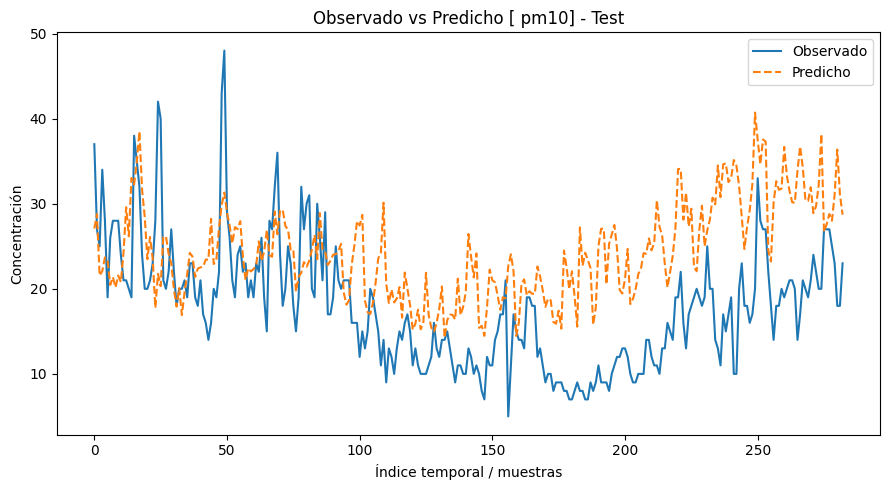


Predicción próximos días:
2020-08-05    31.31
2020-08-06    33.33
2020-08-07    29.36
2020-08-08    32.27
2020-08-09    32.20
2020-08-10    26.37
2020-08-11    28.33
Freq: D, Name: Pred_ pm10, dtype: float64


In [ ]:
# ============================================
#  Air quality: Load → Explore → Model → Predict → Evaluate → Plot
#  Supports Excel/CSV with daily/hourly (date) or annual data (columns 2010, 2011, …)
# ============================================

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ======= CONFIGURACIÓN =======
USE_COLAB_UPLOAD = True        # True si subirás el archivo en Colab
FILENAME = None                # Si trabajas local: e.g., "tu_archivo.xlsx"
TARGET_COL = None              # Si sabes el nombre exacto de la variable objetivo (ej. "PM2.5"), ponlo aquí
FORECAST_STEPS_DAYS = 7        # Días a predecir (modo diario)
# ============================

# ---------------- UTILIDADES ----------------
def try_read_any(path: str) -> pd.DataFrame:
    """Intenta leer CSV/Excel con varios separadores/encodings."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe el archivo: {path}")
    # CSV autodetect
    for enc in ("utf-8", "latin1"):
        try:
            return pd.read_csv(path, sep=None, engine="python", encoding=enc)
        except Exception:
            pass
    # CSV separadores comunes
    for sep in [",", ";", "\t", "|"]:
        for enc in ("utf-8", "latin1"):
            try:
                return pd.read_csv(path, sep=sep, engine="python", encoding=enc)
            except Exception:
                pass
    # Excel
    try:
        return pd.read_excel(path)
    except Exception as e:
        raise RuntimeError(f"No pude leerlo como CSV/Excel. Error final: {e}")

def detect_date_column(df: pd.DataFrame):
    pats = [r"^date$", r"^fecha$", r"^datetime$", r"^time$", r"^timestamp$",
            r"^fechahora$", r".*fecha.*", r".*date.*", r".*time.*"]
    # 1) nombres típicos
    for c in df.columns:
        cl = str(c).strip().lower()
        if any(re.match(p, cl) for p in pats):
            s = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if s.notna().mean() > 0.6:
                return c
    # 2) columnas altamente convertibles
    for c in df.columns:
        s = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
        if s.notna().mean() > 0.9:
            return c
    return None

def detect_year_columns(df: pd.DataFrame):
    out = []
    for c in df.columns:
        sc = str(c).strip()
        if sc.isdigit() and len(sc) == 4:
            y = int(sc)
            if 1900 <= y <= 2100:
                out.append(c)
    return out

def detect_target(df: pd.DataFrame, hint=None):
    if hint and hint in df.columns:
        return hint
    # Patrones típicos PM2.5
    pats = [r"^pm2\.?5$", r"^pm_?2_?5$", r"^pm25$", r".*pm2\.?5.*", r".*pm_?2_?5.*", r".*pm25.*"]
    m = {str(c).lower(): c for c in df.columns}
    for low, orig in m.items():
        if any(re.match(p, low) for p in pats):
            return orig
    # fallback: primera numérica con varianza razonable
    num = df.select_dtypes(include=[np.number])
    for c in num.columns:
        if num[c].nunique() > 10:
            return c
    return None

def evaluate(y_true, y_pred, label="TEST"):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np

    mae = mean_absolute_error(y_true, y_pred)

    # Compatibilidad: si 'squared' no existe, calcula RMSE manualmente
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.4f}  'Precisión'≈{max(0,min(1,r2))*100:.1f}%")
    return mae, rmse, r2


def plot_series(y_true, y_pred, title="Observado vs Predicho"):
    plt.figure(figsize=(9,5))
    plt.plot(y_true, label="Observado")
    plt.plot(y_pred, "--", label="Predicho")
    plt.title(title)
    plt.xlabel("Índice temporal / muestras")
    plt.ylabel("Concentración")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------- 1) CARGAR ----------------
if USE_COLAB_UPLOAD:
    try:
        from google.colab import files
        up = files.upload()
        if len(up):
            FILENAME = list(up.keys())[0]
    except Exception:
        if not FILENAME:
            raise RuntimeError("Sube un archivo o define FILENAME con la ruta local.")

if not FILENAME:
    raise RuntimeError("Define FILENAME con la ruta de tu archivo o usa la carga en Colab.")

df0 = try_read_any(FILENAME)
print("Columnas detectadas:", list(df0.columns))

# Limpieza básica
df = df0.copy()
df = df.dropna(axis=1, how="all").dropna(how="all")

# Detectar fecha/años
date_col = detect_date_column(df)
year_cols = detect_year_columns(df)

# --- añadir utilitario ---
def coerce_numeric_cols(df: pd.DataFrame, exclude: list[str] = None) -> pd.DataFrame:
    """
    Convierte a numérico columnas 'object':
    - quita espacios y símbolos
    - cambia comas por puntos
    - coerce a NaN cuando no se puede convertir
    """
    if exclude is None:
        exclude = []
    for c in df.columns:
        if c in exclude:
            continue
        if df[c].dtype == "object":
            s = df[c].astype(str).str.strip()
            # Limpieza típica de números en texto
            s = s.str.replace(r"[^\d\-\.,]", "", regex=True)
            s = s.str.replace(",", ".", regex=False)
            df[c] = pd.to_numeric(s, errors="coerce")
    return df

# --- después de detectar date_col / year_cols ---
# Si hay columna de fecha, conviértela a datetime ya mismo para excluirla de la coerción
if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# Forzar numéricas en el resto (pm10, o3, no2 estaban como object)
df = coerce_numeric_cols(df, exclude=[date_col] if date_col else [])

# Reemplaza inf por NaN por si acaso
df = df.replace([np.inf, -np.inf], np.nan)
# ---------------- 2) EXPLORAR ----------------
print("\n=== 2) EXPLORAR ===")
print("Forma:", df.shape)
print("Tipos:")
print(df.dtypes.head(15))

print("\nDescripción numérica (primeras columnas):")
numdf = df.select_dtypes(include=[np.number])
if numdf.shape[1] > 0:
    print(numdf.describe().T.head(10))
else:
    print("No se detectaron columnas numéricas (revisa el formato de tus datos).")

# ---------------- 3) MODELAR ----------------
if date_col is not None:
    print("\nModo DIARIO/HORARIO (columna fecha:", date_col, ")")
    # Preparar índice temporal diario
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
    df = df[df[date_col].notna()].sort_values(date_col).set_index(date_col)

    target = detect_target(df, TARGET_COL)
    if target is None:
        raise RuntimeError("No se pudo detectar columna objetivo (p.ej. PM2.5). Especifica TARGET_COL.")
    if target not in df.select_dtypes(include=[np.number]).columns:
        df[target] = pd.to_numeric(df[target], errors="coerce")

    # Si es horario, pasamos a diario (promedio)
    df_daily = df.resample("D").mean().replace([np.inf,-np.inf], np.nan).dropna(subset=[target])
    if len(df_daily) < 30:
        raise RuntimeError("Muy pocos datos diarios tras limpieza para entrenar.")

    # Features de calendario
    base = df_daily.copy()
    base["dayofyear"] = base.index.dayofyear
    base["dow"] = base.index.dayofweek
    base["month"] = base.index.month

    X = base[["dayofyear","dow","month"]].values
    y = base[target].values

    # Split temporal 80/20
    split = int(len(base)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Modelo (Random Forest)
    model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # ---------------- 4) PREDECIR ----------------
    y_pred_test = model.predict(X_test)

    # ---------------- 5) EVALUAR ----------------
    evaluate(y_test, y_pred_test, label="TEST diario")

    # ---------------- 6) GRAFICAR ----------------
    plot_series(y_test, y_pred_test, title=f"Observado vs Predicho [{target}] - Test")

    # Predicción próximos N días
    future_idx = pd.date_range(base.index[-1] + pd.Timedelta(days=1), periods=FORECAST_STEPS_DAYS, freq="D")
    X_future = pd.DataFrame({
        "dayofyear": future_idx.dayofyear,
        "dow": future_idx.dayofweek,
        "month": future_idx.month
    }, index=future_idx)
    y_future = model.predict(X_future.values)
    print("\nPredicción próximos días:")
    print(pd.Series(y_future, index=future_idx, name=f"Pred_{target}").round(2))

elif year_cols:
    print("\nModo ANUAL (columnas año detectadas):", year_cols)
    # Promedio por año (ajústalo a tu caso: por ciudad/estación, etc.)
    year_vals = df[year_cols].apply(pd.to_numeric, errors="coerce")
    s = year_vals.mean(axis=0).dropna()   # serie (años) → valor medio
    s.index = pd.to_datetime(s.index, format="%Y")
    s = s.sort_index()

    X = np.arange(len(s)).reshape(-1,1)  # tiempo simple
    y = s.values

    split = int(len(s)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = LinearRegression().fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    evaluate(y_test, y_pred_test, label="TEST anual")

    # Graficar
    plt.figure(figsize=(9,5))
    plt.plot(s.index[:split], y_train, label="Entrenamiento")
    plt.plot(s.index[split:], y_test, label="Observado [Test]")
    plt.plot(s.index[split:], y_pred_test, "--", label="Predicho [Test]")
    plt.title("Serie anual: Observado vs Predicho")
    plt.xlabel("Año"); plt.ylabel("Concentración (promedio)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Predicción 2 años
    fut_steps = 2
    last_t = X[-1,0]
    X_future = np.arange(last_t+1, last_t+1+fut_steps).reshape(-1,1)
    y_future = model.predict(X_future)
    future_years = pd.date_range(s.index[-1] + pd.offsets.YearBegin(1), periods=fut_steps, freq="YS")
    print("\nPredicción anual (próximos años):")
    print(pd.Series(y_future, index=future_years, name="Pred_anual").round(2))

else:
    raise RuntimeError(
        "No detecté columna de fecha ni columnas de años. "
        "Asegúrate de que tu dataset tenga una columna de fecha (p.ej. 'Fecha') "
        "o columnas con nombres de años (2010,2011,...)."
    )
